### This notebook consist of the main algorithm implementation. Data is randomly sampled, the sample with the optimal runtime - community quality is chosen, then the modularity value for that sample is calculated using sknetwork, with constructing the biadjacency matrix and obtaining the community labels for nodes. Then the results for chosen dataset is compared with results from other algorithms. It takes approx. 15 mins. to run this notebook if scikit-network is already installed.

_This cell below is just the code Hannah wrote for our implementation. It is copied here to be able to see if an error raises in the process to solve it more easily, as the functions defined here will be used for analysis._

In [1]:
"""
This module contains our implementation of the bilouvain algorithm from the following paper:
C. Zhou, L. Feng, and Q. Zhao, “A novel community detection method in bipartite networks,” 
Physica A: Statistical Mechanics and its Applications, vol. 492, pp. 1679–1693, Feb. 2018, 
doi: 10.1016/j.physa.2017.11.089.

Group: Sema Aydin, Hannah Portmann, Diogo Rocha
Implementation: Hannah Portmann
"""

import networkx as nx
import numpy as np

def set_weights_to_one(G):
    """
    Set all weights of the edges in the graph to one in the beginning of the algorithm

    Parameters:
    G: graph

    Returns:
    Nothing, outcome is that all edges of graph G now have an edge weight of 1
    """
    for u, v in G.edges():
        G[u][v]['weight'] = 1


def set_group_order(G):
    """
    Set the order of the groups because the algorithm needs to start with the larger group (here called group red)

    Parameters:
    G: bipartite graph with the attribute node_type with values 'top' and 'bottom' for the two node groups

    Returns:
    groups: dictionary with keys 'red' and 'blue' and the corresponding group of nodes as values
    """
    top_nodes = {n for n, d in G.nodes(data=True) if d["node_type"] == "top"}
    bottom_nodes = set(G) - top_nodes

    # find the longer set of nodes to start with
    # the longer group will be called group red
    if len(top_nodes) > len(bottom_nodes):
        node_group_red = top_nodes
        node_group_blue = bottom_nodes
    else:
        node_group_red = bottom_nodes
        node_group_blue = top_nodes

    groups = {'red': node_group_red, 'blue': node_group_blue}
    return groups


def find_neighbor_communities(G, node, community_assignments):
    """
    Given a node, find the neighboring communities in graph G (depending on the current community_assignments).

    Parameters:
    G: bipartite graph
    node: node that we want to find the neighboring communities of
    community_assignments: dict which contains current communities

    Returns:
    neighboring_communities: set which contains all communities that are directly connected to node
    """
    neighboring_communities = set()

    for community in community_assignments.values():  # check if communities are neighboring to our current node

        # if the node we want to check is in the community already, it must be a neighboring community (except for first iteration, when the node itself is a community - then it is excluded again when checking the length)
        # if the node we want to check is in the community, we need to remove it from that community to check the modularity gain
        if node in community:
            community_copy = set(community)
            community_copy.remove(node)
            if len(community_copy) != 0:  # make sure that it is not an empty community after removing the node
                neighboring_communities.add(tuple(community_copy))  # Add the modified community

        # find the communities that include neighbors of the current node
        else:
            for node_b in community:
                if node_b != node and G.has_edge(node_b, node):
                    neighboring_communities.add(tuple(community))

    return neighboring_communities


def bipartite_modularity_gain(G, node_i, community, group):
    """
    Compute the modularity gain of moving node_i to community. 

    Parameters:
    G: bipartite graph
    node_i: node that we move into community
    community: community that node is moved into
    group: node group of node_i

    Returns:
    delta_q: bipartite modularity gain of moving node_i into community
    """
    comm_other = [node for node in community if
                  node not in group]  # only take into account nodes in community from other node group
    m = sum([data['weight'] for _, _, data in G.edges(data=True)])  # Total sum of edge weights

    edges = G.edges(node_i, data=True)  # find edges incident to node_i
    edges_in_community = [(u, v, data['weight']) for u, v, data in edges if
                          v in comm_other]  # edges and edge weights of edges between node_i and community
    k_i_in = sum(weight for _, _, weight in edges_in_community)  # sum of edge weights in community

    comm_other_edges = [(u, v, data['weight']) for u, v, data in
                        G.edges(comm_other, data=True)]  # edges and edge weights of community nodes in other group
    community_degree = sum(weight for _, _, weight in
                           comm_other_edges)  # sum of degrees considering weight of nodes of other group in community

    # compute modularity gain
    delta_q = k_i_in / m - G.degree(node_i, weight='weight') * community_degree / m ** 2

    return delta_q


def move_node(node, add_community, community_assignments):
    """
    Move a node to a new community and update the community assignments.

    Parameters:
    node: node that should be moved
    add_community: community to which node will be added
    community_assignment: dict containing current communities

    Returns:
    community_assignments: dict which contains the changed communities, where node is now in add_community
    """
    add_community_key, remove_community_key = None, None

    for i, community in community_assignments.items():  # iterate over communities
        if add_community.issubset(community):  # find add community index where node has to be added
            add_community_key = i
        elif node in community:  # find index of community node has to be removed from
            remove_community_key = i

    if add_community_key is not None:
        community_assignments[add_community_key].add(node)  # add node to new community

    if remove_community_key is not None:
        community_assignments[remove_community_key].remove(node)  # remove node from old community
        if len(community_assignments[
                   remove_community_key]) == 0:  # if the community the node was removed from is empty -> delete community
            del community_assignments[remove_community_key]

    return community_assignments


def assignment(G, group, community_assignments):
    """
    Assignment step: assign nodes of current node group to communities.

    Parameters:
    G: bipartite graph
    group: list of nodes in current group, nodes of this group are assigned to communities
    community_assignments: dict which contains the current communities as values

    Returns:
    new_assignments: new dict which contains the new communities
    """
    new_assignments = community_assignments.copy()

    for node in group:  # go over all nodes of the current node group

        # find all neighboring communities
        neighboring_communities = find_neighbor_communities(G, node, new_assignments)

        max_delta_Q = 0

        # calculate modularity gain for all neighboring communities and keep only largest one
        for community in neighboring_communities:
            delta_Q = bipartite_modularity_gain(G, node, community, group)
            if delta_Q > max_delta_Q:
                max_delta_Q = delta_Q
                max_community = set(community)

        # update community of that node
        if max_delta_Q > 0:  # only update if positive modularity gain (if max_delta_Q is still 0, there was no positive modularity gain found)
            new_assignments = move_node(node, max_community, new_assignments)

    # If there were changes in the community assignments, we do the same again with the new community assignments
    if new_assignments != community_assignments:
        assignment(G, group, new_assignments)

    # check if isolated nodes of the group assist, if yes, assign them randomly
    for node in group:
        for community_key, community in new_assignments.items():
            if node in community:
                if len(community) == 1:
                    neighboring_communities = find_neighbor_communities(G, node, new_assignments)
                    random_community = list(neighboring_communities)[0]
                    new_assignments = move_node(node, random_community, new_assignments)

    return new_assignments  # return the communities when there are no changes anymore


def aggregation(group, group_key, community_assignments, G, iteration):
    """
    Aggregation step: aggregate nodes of current node group to hypernodes.

    Parameters:
    group: list of nodes belonging to current group, from which the nodes will be aggregated to hypernodes
    group_key: key of current group (red or blue)
    community_assignments: dict containing current communities
    G: biparite graph
    iteration: integer that indicates current iteration, used to name hypernodes

    Returns:
    H: new hypergraph, where nodes from group which are in the same community are aggregated to hypernodes
    hypernodes: dict, which contains the names of hypernodes as keys and the values are the original nodes that were aggregate to that hypernode
    new_assignments: dict containing the new community assignments, where the nodes from group are replaced by hypernodes
    """
    H = nx.Graph()  # create new hypergraph
    hypernodes = dict()  # create dict for storing hypernodes
    new_assignments = dict()

    # define color of hypernode for hypernode id
    if group_key == 'red':
        x = 'r'
    else:
        x = 'b'

    # first we add all necessary nodes to the graph
    for community_id, nodes in community_assignments.items():
        new_assignments[community_id] = set()

        agg_nodes = []  # find nodes that need to be aggregated to hypernode
        for node in nodes:
            if node in group:  # nodes from current group are aggregated
                agg_nodes.append(node)
            else:  # nodes from other group are not aggregated
                H.add_node(node)  # nodes from other group are not changed
                new_assignments[community_id].add(node)

        if len(agg_nodes) > 0:  # create hypernode if there are nodes to be aggregated
            hypernode_id = f'{x}_{iteration}_{community_id}'  # define name of hypernode
            H.add_node(hypernode_id)  # add hypernode to hypergraph
            hypernodes[hypernode_id] = agg_nodes  # store original nodes of hypernode
            new_assignments[community_id].add(hypernode_id)

    # then we add all the edges
    for hypernode_id, nodes in hypernodes.items():
        for node in nodes:  # find edges of hypernode
            neighbors = G.neighbors(node)
            for neighbor in neighbors:
                if not H.has_edge(hypernode_id, neighbor):  # add edge if it does not exist yet
                    edge_weight = G[node][neighbor].get('weight')
                    H.add_edge(hypernode_id, neighbor,
                               weight=edge_weight)  # add edge with weight it had in Graph before
                else:
                    edge_weight = G[node][neighbor].get('weight')
                    current_weight = H[hypernode_id][neighbor].get(
                        'weight')  # if edge already exists, add 1 to weight for additional edge in original graph
                    new_weight = current_weight + edge_weight
                    H[hypernode_id][neighbor]['weight'] = new_weight  # update weight of edge

    return H, hypernodes, new_assignments


def add_rows_and_columns(matrix, i, j):
    """
    Adds rows i and j and columns i and j of matrix (m x m) together.

    Parameters:
    matrix: original similarity matrix
    i: index of community 1 that should be combined with community 2
    j: index of community 2 that should be combined with community 1

    Returns:
    matrix: new matrix (m-1 x m-1), where rows i and j and columns i and j were added together
    """
    matrix[i] = matrix[i] + matrix[j]
    matrix = np.delete(matrix, j, axis=0)
    matrix[:, i] = matrix[:, i] + matrix[:, j]
    matrix = np.delete(matrix, j, axis=1)
    return matrix


def find_max_indices_and_update(S):
    """
    Finds the index of the maximum value in the matrix S and if the value is positive, combines the rows and columns of those indices.

    Parameters: 
    S: similarity matrix, element S_i_j represents modularity gain of combining communities i and j

    Returns:
    max_indices: the indices of the maximum value in matrix S, if this value is positive, e.g. i and j
    S_new: matrix S, where the rows i and j and columns i and j were added together, representing the combination of those communities
    """
    max_indices = np.unravel_index(np.argmax(S), S.shape)
    if S[max_indices] > 0:
        S_new = add_rows_and_columns(S, max_indices[0], max_indices[1])
        return max_indices, S_new
    else:
        return None, None


def combine_communities(community_order, max_indices, community_assignments):
    """ 
    Now also combining two communities in the community assignments.

    Parameters:
    community_order: ordered list of communities, to identify communities by index
    max_indices: indices of two communities that should be combined
    community_assignments: dict with current communities

    Returns:
    community_assignments: dict with new communities, where the two communities are combined
    community_order: updated ordered list of communities, where the two communities are combined
    """
    comm_1 = community_order[max_indices[0]]
    comm_2 = community_order[max_indices[1]]

    community_assignments[comm_1] = community_assignments[comm_1] | community_assignments[comm_2]
    community_assignments.pop(comm_2)

    community_order.remove(comm_2)

    return community_assignments, community_order


def recursive_update(G, m, community_assignments, S, community_order):
    """
    Updates community_assignments and S recursively, until no combination of communities leads to modularity gain anymore.

    Parameters:
    G: bipartite Graph, currently containg hypernodes created by previous assignment and aggregation steps
    m: number of edges in original graph (corresponds to sum of edge weight in current graph G)
    community_assignments: dict with current communities
    S: similarity matrix, element S_i_j represents modularity gain of combining communities i and j
    community_order: list of sorted community_ids

    Returns:
    community_assignments: final communities of hypernodes, where no combination of communities would increase modularity anymore
    """
    max_indices, S_new = find_max_indices_and_update(S)

    if max_indices is not None and S_new is not None:
        community_assignments_new, community_order_new = combine_communities(community_order, max_indices,
                                                                             community_assignments)
        return recursive_update(G, m, community_assignments_new, S_new, community_order_new)

    else:
        return community_assignments


def clustering(G, m, community_assignments):
    """
    Clustering algorithm implementation in matrix form. Communities are combined, if their combination increases bipartite modularity. 
    
    Parameters:
    G: bipartite Graph, currently containg hypernodes created by previous assignment and aggregation steps
    m: number of edges in original graph (corresponds to sum of edge weight in current graph G)
    community_assignments: dict with current communities

    Returns:
    Result of recursive_update function
    The following new parameters are given to this function:
    S: similarity matrix, element S_i_j represents modularity gain of combining communities i and j
    community_order: list of sorted community_ids
    """
    community_order = sorted([community_id for community_id in community_assignments.keys()])
    sorted_nodes_blue = [node for community_id in community_order for node in community_assignments[community_id] if
                         node.startswith('b')]
    sorted_nodes_red = [node for community_id in community_order for node in community_assignments[community_id] if
                        node.startswith('r')]
    sorted_nodes = sorted_nodes_blue + sorted_nodes_red
    
    comm_len = len(community_order)

    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted_nodes)
    adj_matrix = adj_matrix.toarray()

    R = adj_matrix[comm_len:, :comm_len]
    e = np.ones((comm_len, 1))
    d = np.dot(R, e)
    g = np.dot(R.T, e)

    S = 1 / m * (R + R.T - (np.dot(d, g.T) + np.dot(g, d.T)) / m)
    np.fill_diagonal(S, -np.inf)

    return recursive_update(G, m, community_assignments, S, community_order)

def unpack_hypernodes(node, all_hypernodes):
    """
    Unpack hypernode recursively to find original nodes which were aggregated to hypernode.

    Parameters:
    node: hypernode, which has to be unpacked
    all_hypernodes: dict which contains for each hypernode a list of nodes, which were aggregated to that hypernode

    Returns: 
    List of original nodes contained in a hypernode
    """
    if node in all_hypernodes:
        return [unpack_hypernodes(sub_node, all_hypernodes) for sub_node in all_hypernodes[node]]
    else:
        return [node]


def flatten(nested_list):
    """
    Flatten nested list which was created by unpack_hypernodes function.

    Parameters:
    nested_list: nested list that originates when hypernodes are unpacked

    Returns: 
    1 dimensional list containing nodes from nested_list
    """
    if len(nested_list) == 0:
        return nested_list
    if isinstance(nested_list[0], list):
        return flatten(nested_list[0]) + flatten(nested_list[1:])
    return nested_list[:1] + flatten(nested_list[1:])


def final_communities(community_assignments, all_hypernodes):
    """
    Find communities of original nodes by unpacking all hypernodes.

    Parameters:
    community_assignments: dict with current community_assignments, containing hypernodes
    all_hypernodes: dict containing information about which nodes were aggregated to form a hypernode

    Returns:
    final_community_ass: final assignments of communities, containing only the original nodes of the graph given to the algorithm
    """
    final_community_ass = dict()

    # go through communities
    for community_id, nodes in community_assignments.items():
        final_community_ass[community_id] = []

        # go through nodes in communities and unpack them
        for node in nodes:
            final_community_ass[community_id].extend(unpack_hypernodes(node, all_hypernodes))

        # flatten found final communities
        final_community_ass[community_id] = flatten(final_community_ass[community_id])

    return final_community_ass


def bilouvain(Graph):
    """
    Main function to find communities in a bipartite graph according to bilouvain algorithm by Zhou et al. (2018).
    
    Parameters:
    Graph: a bipartite graph with node attributes "node_type" set to the values "top" and "bottom"

    Returns: 
    final_community_assignments: dictionary with the final communities as values, the key does not have any meaning anymore
    """

    G = Graph.copy()
    m = G.number_of_edges()
    set_weights_to_one(G)  # set all weights in graph to one to begin with (make sure they have attribute weight)
    groups = set_group_order(G)  # set which group of nodes comes first (longer one)

    # initialize communities
    community_assignments = {i: {n} for i, n in enumerate(G)}

    all_hypernodes = dict()  # initialize dict where the contents of all hypernodes will be stored

    # create variables for stop condition
    no_change_red = False
    no_change_blue = False

    i = 0  # count iterations

    while not no_change_red or not no_change_blue:  # if there are no more changes in both community assignment steps, the loop stops

        i += 1  # increase iteration by one (for naming hypernodes)
#         print(f'iteration: {i}')

        # assignment on red nodes
        community_assignments_before = community_assignments.copy()
        community_assignments = assignment(G, groups['red'], community_assignments)
        if community_assignments == community_assignments_before:
            no_change_red = True

        # aggregation on red nodes
        G, hypernodes, community_assignments = aggregation(groups['red'], 'red', community_assignments, G, iteration=i)
        groups['red'] = list(hypernodes.keys())
        all_hypernodes.update(hypernodes)

        # assignment on blue nodes
        community_assignments_before = community_assignments.copy()
        community_assignments = assignment(G, groups['blue'], community_assignments)
        if community_assignments == community_assignments_before:
            no_change_blue = True

        # aggregation on blue nodes
        G, hypernodes, community_assignments = aggregation(groups['blue'], 'blue', community_assignments, G,
                                                           iteration=i)
        groups['blue'] = list(hypernodes.keys())
        all_hypernodes.update(hypernodes)

    # clustering step on balanced communities
    community_assignments = clustering(G, m, community_assignments)

    # find final communities with original nodes
    final_community_assignments = final_communities(community_assignments, all_hypernodes)

    return final_community_assignments

**The cells below are Sema's work on network evaluation.**

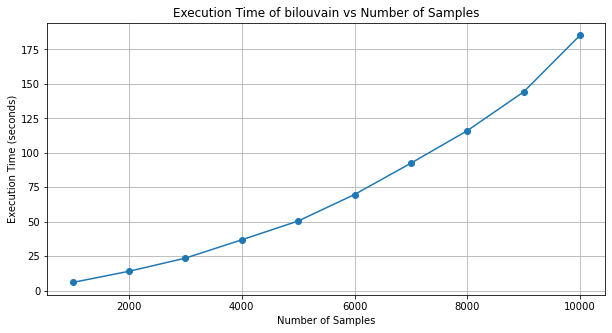

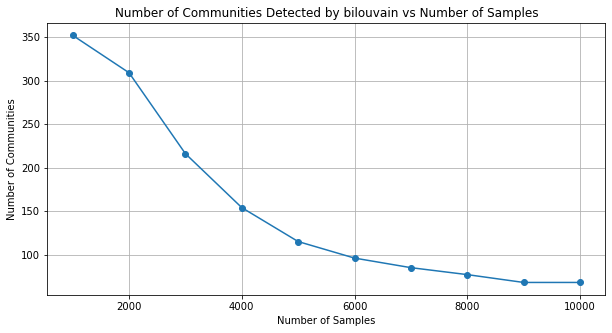

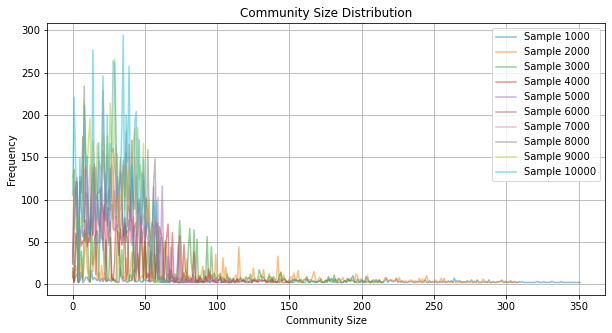

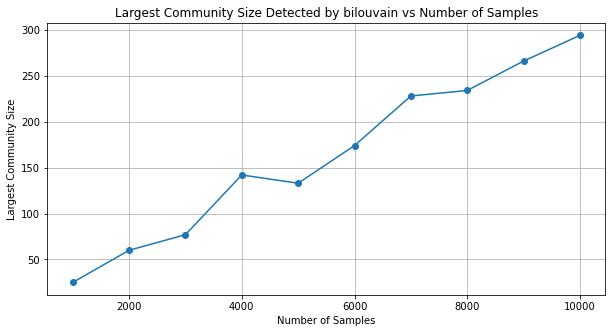

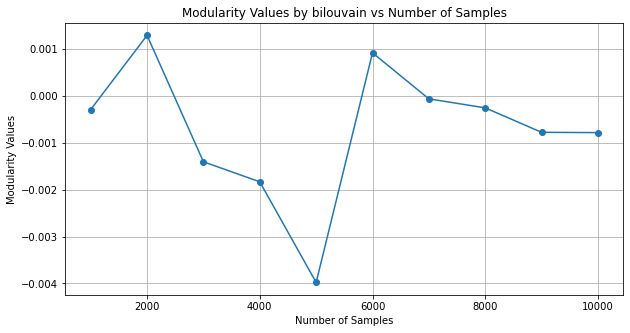


Execution Times:
Sample with 1000 entries took 5.90 seconds to run bilouvain.
Sample with 2000 entries took 14.02 seconds to run bilouvain.
Sample with 3000 entries took 23.56 seconds to run bilouvain.
Sample with 4000 entries took 36.85 seconds to run bilouvain.
Sample with 5000 entries took 50.49 seconds to run bilouvain.
Sample with 6000 entries took 69.70 seconds to run bilouvain.
Sample with 7000 entries took 92.44 seconds to run bilouvain.
Sample with 8000 entries took 116.02 seconds to run bilouvain.
Sample with 9000 entries took 144.16 seconds to run bilouvain.
Sample with 10000 entries took 185.21 seconds to run bilouvain.


In [2]:
# !pip install scikit-network
from IPython.display import SVG
from sknetwork.clustering import Louvain, Leiden, get_modularity
from sknetwork.linalg import normalize
from sknetwork.utils import get_membership
from scipy import sparse

from sknetwork.visualization import visualize_bigraph
import numpy as np
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
from sknetwork.data import from_edge_list


# Function to run bilouvain and record execution time and community details
def run_bilouvain_on_sample(sample_df):
    # Create graph
    G = nx.Graph()
    G.add_nodes_from(sample_df['user'].unique(), bipartite=0)
    G.add_nodes_from(sample_df['title'].unique(), bipartite=1)
    G.add_edges_from(sample_df[['user', 'title']].values)
    
    # Set node types
    users = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
    movies = {n for n, d in G.nodes(data=True) if d['bipartite'] == 1}
    node_types = {node:'top' if node in users else 'bottom' for node in G.nodes}
    nx.set_node_attributes(G, node_types, name="node_type")
    
    # Run bilouvain and measure execution time
    start_time = time.time()
    communities = bilouvain(G)
    end_time = time.time()
    execution_time = end_time - start_time
    
    # using sknet to obtain the biadjacency matrix of the graph
    
    # Create edge list for sknetwork
    edge_list = list(sample_df.itertuples(index=False))

    # Obtain biadjacency matrix
    graph = from_edge_list(edge_list, bipartite=True)
    biadjacency = graph.biadjacency

    labels_row = np.zeros(len(users), dtype=int)  # Initialize labels for users as integers
    labels_col = np.zeros(len(movies), dtype=int)  # Initialize labels for movies as integers

    for label, nodes in communities.items():
        for node in nodes:
            if node in users:
                user_index = list(users).index(node)
                labels_row[user_index] = int(label) # np.array containing labels for users
            elif node in movies:
                movie_index = list(movies).index(node)
                labels_col[movie_index] = int(label) # np.array containing labels for movies


    modularity = get_modularity(biadjacency, labels_row, labels_col)
        
    # Get community sizes
    community_sizes = [len(nodes) for nodes in communities.values()]
    num_communities = len(community_sizes)

    return execution_time, community_sizes,  num_communities, modularity

# Import file
data = pd.read_csv('./Data/lboxd_IDcoded.csv')
letterboxd = data.drop(['rating', 'movie_id'], axis=1)

# Sample dataframes using random number of rows
sample_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

sampled_random_dataframes = {}
for size in sample_sizes:
    random_sample = letterboxd.sample(n=size, random_state=42)
    sampled_random_dataframes[size] = random_sample

# Record execution time, community sizes, and number of communities
execution_times = {}
community_sizes_per_sample = {}
num_communities_per_sample = {}
largest_community_size_per_sample = {}
modularities_per_sample = {}

for size, sample_df in sampled_random_dataframes.items():
    ex_time, community_sizes, num_communities, modularity = run_bilouvain_on_sample(sample_df)
    execution_times[size] = ex_time
    community_sizes_per_sample[size] = community_sizes
    num_communities_per_sample[size] = num_communities
    largest_community_size_per_sample[size] = max(community_sizes)
    modularities_per_sample[size] = modularity


# Plot execution time vs sample size
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, list(execution_times.values()), marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time of bilouvain vs Number of Samples')
plt.grid(True)
plt.show()

# Plot number of communities vs sample size
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, list(num_communities_per_sample.values()), marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Communities')
plt.title('Number of Communities Detected by bilouvain vs Number of Samples')
plt.grid(True)
plt.show()

# Plot community sizes for each sample size
plt.figure(figsize=(10, 5))
for size, community_sizes in community_sizes_per_sample.items():
    plt.plot(community_sizes, alpha=0.5, label=f'Sample {size}')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.title('Community Size Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Plot largest community size vs sample size
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, list(largest_community_size_per_sample.values()), marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Largest Community Size')
plt.title('Largest Community Size Detected by bilouvain vs Number of Samples')
plt.grid(True)
plt.show()

# Plot number of communities vs sample size
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, list(modularities_per_sample.values()), marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Modularity Values')
plt.title('Modularity Values by bilouvain vs Number of Samples')
plt.grid(True)
plt.show()

# Print execution times
print("\nExecution Times:")
for size, ex_time in execution_times.items():
    print(f"Sample with {size} entries took {ex_time:.2f} seconds to run bilouvain.")


Initially, the sample with 5000 entries (edges) was chosen as the sample set with optimal trade-off since from the graphs, it can be seen that the number and sizes of the communities don't change significantly while runtime increases too much above the 1 min. threshold for larger sample sizes. We took 1 min. as a threshold since other community detection algorithms take less than a minute for the whole dataset and we wanted to avoid having a too large margin to make a reasonable comparison.

However the modularity value (modularity: -0.002344719999999946) was too low and number of communities was too large (community: 115, size: 2). These values can be considered as out of the margin for comparison with other algorithms since they have modularity values around 0.20, and a negative modularity value means the network performs worse than a random one, so we changed our decision to use the sample with 10000 edges, as it can give a better result. However, the modularity value for 10000 edges was -0.0011382650000001868 and community number was not decreasing too much (community: 65, size: 2). 

Then we plotted the modularity for each sample to see where the turning point is. As seen from the figure and the code below the highest modularity is obtained from the sample with 9000 entries. Since it took around 2-3 mins. we think it is the best trade-off we can obtain and continue our evaluations with this sample set.

We also changed the random state parameter a lot with values like 1,10,15,42,99. We use the random state parameter to ensure reproducibility. Nonetheless, the results significantly vary between each run. While the execution time, number of communities detected, largest community size detected follow the same increasing trend in each run, the values differ for each run. Furthermore, modularity values don't show a tendency for a direction, neither for running the algorithm one time for different samples, nor for comparing different runs of the algorithm. This is because the algorithm detects different communities based on the order of nodes, the nodes with equal modularity gain are added to the first community detected with the highest modularity gain, and each run the order changes.

In [3]:
max_modularity_value = max(modularities_per_sample.values())
max_modularity_sample = max(modularities_per_sample, key=modularities_per_sample.get)
print(f"The maximum modularity value is {max_modularity_value} for the sample with {max_modularity_sample} entries.")

The maximum modularity value is 0.0012844999999999922 for the sample with 2000 entries.


In [4]:
# getting the community labels for the sample we have chosen using our bilouvain implementation

# Import file
lboxd = sampled_random_dataframes[9000]

# create graph
G_sample = nx.Graph()
G_sample.add_nodes_from(lboxd['user'].unique(), bipartite=0)
G_sample.add_nodes_from(lboxd['title'].unique(), bipartite=1)
G_sample.add_edges_from(lboxd[['user', 'title']].values)

# Get the sets of nodes
users_sample = {n for n, d in G_sample.nodes(data=True) if d['bipartite'] == 0}
movies_sample = {n for n, d in G_sample.nodes(data=True) if d['bipartite'] == 1}

# Print the number of nodes in the sets
print(f"number of users in the sample set: {len(users_sample)}")
print(f"number of movies in the sample set: {len(movies_sample)}")

node_types = {node:'top' if node in users_sample else 'bottom' for node in G_sample.nodes}

nx.set_node_attributes(G_sample, node_types, name="node_type")

start_time = time.time()

communities_sample = bilouvain(G_sample)

end_time = time.time()
ex_time = end_time - start_time
print(f"execution time: {ex_time}")

number of users in the sample set: 545
number of movies in the sample set: 6477
execution time: 154.7675564289093


In [5]:
# using sknet to obtain the biadjacency matrix of the graph

df = sampled_random_dataframes[9000]

edge_list = list(df.itertuples(index=False))
graph_sample = from_edge_list(edge_list, bipartite=True)
biadjacency_sample = graph_sample.biadjacency

names_row = graph_sample.names_row # users
names_col = graph_sample.names_col # movies

labels_row = np.zeros(len(users_sample), dtype=int)  # Initialize labels for users as integers
labels_col = np.zeros(len(movies_sample), dtype=int)  # Initialize labels for movies as integers

for label, nodes in communities_sample.items():
    for node in nodes:
        if node in users_sample:
            user_index = list(users_sample).index(node)
            labels_row[user_index] = int(label) # np.array containing labels for users
        elif node in movies_sample:
            movie_index = list(movies_sample).index(node)
            labels_col[movie_index] = int(label) # np.array containing labels for movies

i=0
for community, nodes in communities_sample.items():
    i+=1
    print(f"community: {community}, size: {len(nodes)}")
print(f"number of communities: {i}")

modularity = get_modularity(biadjacency_sample, labels_row, labels_col)
print(f"modularity: {modularity}") # barber's modularity by default
# image = visualize_bigraph(biadjacency, names_row, names_col, labels_row, labels_col)
# SVG(image)

community: 0, size: 126
community: 1, size: 135
community: 2, size: 65
community: 3, size: 78
community: 4, size: 3
community: 5, size: 58
community: 6, size: 79
community: 7, size: 68
community: 8, size: 216
community: 9, size: 165
community: 11, size: 131
community: 12, size: 172
community: 15, size: 196
community: 16, size: 93
community: 17, size: 170
community: 18, size: 120
community: 19, size: 100
community: 20, size: 166
community: 21, size: 148
community: 23, size: 140
community: 24, size: 134
community: 25, size: 178
community: 26, size: 161
community: 30, size: 110
community: 31, size: 175
community: 32, size: 118
community: 33, size: 214
community: 36, size: 163
community: 39, size: 64
community: 40, size: 266
community: 42, size: 131
community: 45, size: 154
community: 46, size: 61
community: 48, size: 105
community: 49, size: 100
community: 50, size: 137
community: 57, size: 88
community: 61, size: 145
community: 66, size: 86
community: 68, size: 137
community: 73, size: 1

The community labels don't reflect the correct number of communities since they are in nonconsecutive manner. The correct number of communities can be seen from the plot and the dictionary num_communities_per_sample.

In [6]:
# Clustering using bilouvain

start_time = time.time()

louvain = Louvain()
louvain.fit(biadjacency_sample)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

end_time = time.time()
ex_time = end_time - start_time
print(f"execution time for bilouvain: {ex_time}")

execution time for bilouvain: 0.015619754791259766


In [7]:
modularity_bilouvain = get_modularity(biadjacency_sample, labels_row, labels_col)
print(f"modularity for bilouvain: {modularity_bilouvain}") # corresponds to barber's modularity by default

modularity for bilouvain: 0.7747004320987655


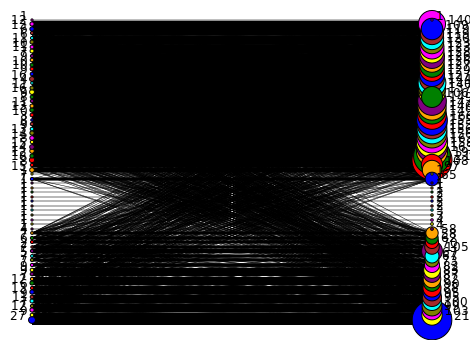

In [8]:
# aggregate graph
biadjacency_aggregate = louvain.aggregate_
labels_unique_row, counts_row = np.unique(labels_row, return_counts=True)
labels_unique_col, counts_col = np.unique(labels_col, return_counts=True)

image = visualize_bigraph(biadjacency_aggregate, counts_row, counts_col, labels_unique_row, labels_unique_col,
                    display_node_weight=True, node_weights_row=counts_row, node_weights_col=counts_col)
SVG(image)

In [9]:
print(len(labels_row)) # total number of users

545


In [10]:
len(labels_col) # total number of movies

6477

In [11]:
len(set(labels_col)) # number of communities

67

In [12]:
# Clustering using Leiden

start_time = time.time()
leiden = Leiden()
leiden.fit(biadjacency_sample)
labels_row = leiden.labels_row_
labels_col = leiden.labels_col_

end_time = time.time()
ex_time = end_time - start_time
print(f"execution time for Leiden: {ex_time}")

execution time for Leiden: 0.03126859664916992


In [13]:
modularity_leiden = get_modularity(biadjacency_sample, labels_row, labels_col)
print(f"modularity for leiden: {modularity_leiden}") # corresponds to barber's modularity by default

modularity for leiden: 0.7758808765432099


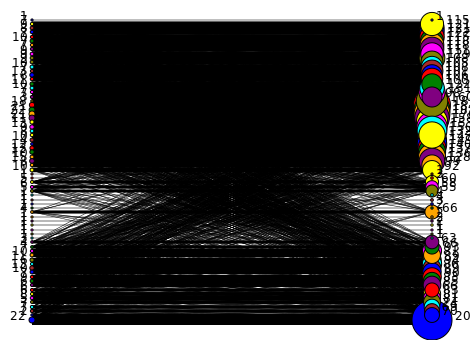

In [14]:
# aggregate graph
biadjacency_aggregate = leiden.aggregate_
labels_unique_row, counts_row = np.unique(labels_row, return_counts=True)
labels_unique_col, counts_col = np.unique(labels_col, return_counts=True)
image = visualize_bigraph(biadjacency_aggregate, counts_row, counts_col, labels_unique_row, labels_unique_col,
                    display_node_weight=True, node_weights_row=counts_row, node_weights_col=counts_col)
SVG(image)

In [15]:
len(set(labels_col)) # number of communities

71

In [16]:
print(len(labels_row)) # total number of users

545


In [17]:
len(labels_col) # total number of movies

6477

In [18]:
# Unipartite louvain

import community

# Import file
lboxd = sampled_random_dataframes[9000]

# create graph
mygraph = nx.Graph()
mygraph.add_nodes_from(lboxd['user'].unique())
mygraph.add_nodes_from(lboxd['title'].unique())
mygraph.add_edges_from(lboxd[['user', 'title']].values)

# Perform community detection using Louvain method
start_time = time.time()
louvain_communities = community.best_partition(mygraph)

end_time = time.time()
ex_time = end_time - start_time
print("Execution time:", ex_time, "seconds")

# Reverse the dictionary to get communities as keys
louvain_communities_reversed = {}
for node, com in louvain_communities.items():
    if com not in louvain_communities_reversed:
        louvain_communities_reversed[com] = [node]
    else:
        louvain_communities_reversed[com].append(node)

for community, nodes in louvain_communities_reversed.items():
    print(f"community: {community}, size: {len(nodes)}")

Execution time: 0.6498353481292725 seconds
community: 0, size: 65
community: 1, size: 156
community: 2, size: 176
community: 3, size: 69
community: 4, size: 3
community: 5, size: 150
community: 6, size: 149
community: 7, size: 157
community: 8, size: 152
community: 9, size: 127
community: 10, size: 166
community: 40, size: 137
community: 12, size: 143
community: 13, size: 85
community: 14, size: 158
community: 15, size: 118
community: 16, size: 106
community: 17, size: 58
community: 18, size: 140
community: 19, size: 70
community: 20, size: 131
community: 21, size: 118
community: 22, size: 111
community: 23, size: 130
community: 24, size: 101
community: 25, size: 133
community: 26, size: 133
community: 27, size: 127
community: 28, size: 171
community: 29, size: 104
community: 30, size: 174
community: 31, size: 143
community: 32, size: 178
community: 33, size: 102
community: 34, size: 114
community: 35, size: 77
community: 36, size: 115
community: 37, size: 99
community: 38, size: 85
co

In [19]:
print(len(louvain_communities_reversed)) # number of communities

71


In [20]:
community_list = [[] for _ in range(max(louvain_communities.values()) + 1)]
for node, com in louvain_communities.items():
    community_list[com].append(node)

modularity_louvain_uni = nx.community.modularity(mygraph, community_list)
print(f"modularity value for unipartite louvain: {modularity_louvain_uni}")

modularity value for unipartite louvain: 0.7751387283950619


In [22]:
for label, nodes in louvain_communities_reversed.items():
    for node in nodes:
        if node in users_sample:
            user_index = list(users_sample).index(node)
            labels_row[user_index] = int(label) # np.array containing labels for users
        elif node in movies_sample:
            movie_index = list(movies_sample).index(node)
            labels_col[movie_index] = int(label) # np.array containing labels for movies
            
modularity_unipartite_louvain = get_modularity(biadjacency_sample, labels_row, labels_col)
print(f"bipartite modularity for unipartite louvain: {modularity_unipartite_louvain}") # barber's modularity 

bipartite modularity for unipartite louvain: 0.00023862345679021013
